In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

/gscratch/bdata/mikeam/anaconda3/envs/TSandLang/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Generate Synthetic time series and description

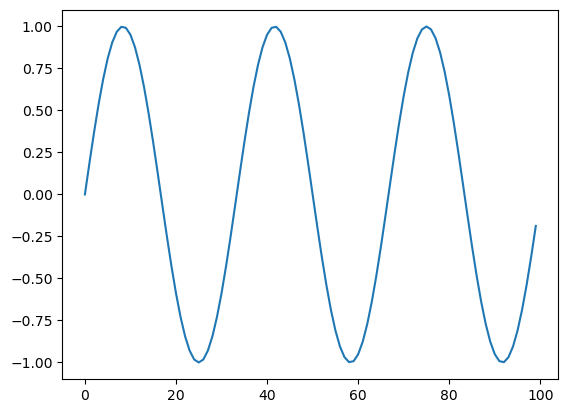

In [2]:
# Frequency and sampling rate
frequencies = [3]
sampling_rate = 100 # Num timesteps
t = np.arange(0, 1, 1/sampling_rate)
y = np.zeros((sampling_rate))

# Create synthetic time series by combining sine waves
for f in frequencies:
    y += np.sin(2 * np.pi * f * t)

x = torch.tensor(y).reshape(1, sampling_rate).float()

plt.plot(x.squeeze())
plt.show()

In [3]:
# --- Write a task description to prompt the model with ---
prompt = "Describe this time series: "

# --- Write text description for this time series ---
desc = "This is a time series for seasonal temperature in celsius that spans {} years."
desc_right = desc.format(frequencies[0])
desc_wrong = [desc.format(i) for i in [-4, 8, 400]]

# Key idea: We have a prompt like "Describe this time series: <|ts_token|>. Description: This time series is a ..."

### Create time series embedding model

In [4]:
class TimeSeriesEncoder(torch.nn.Module):
    def __init__(self, num_timesteps, embed_dim):
        """Linear layer from time series values to embedding dim"""
        super(TimeSeriesEncoder, self).__init__()
        self.fc = torch.nn.Linear(num_timesteps, embed_dim)
        
    def forward(self, x):
        return self.fc(x)

In [5]:
# --- simple example ---
ts_enc = TimeSeriesEncoder(num_timesteps=100, embed_dim=512)
test_embed = ts_enc(x.float())
print(test_embed.shape)

torch.Size([1, 512])


In [6]:
model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-70m-deduped")
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m-deduped")
embed_dim = model.config.hidden_size # Model has 512-dimensional embeddings

# --- turn grads off on model ---
for p in model.parameters():
    p.requires_grad = False

# --- define new time series token and add it to the tokenizer ---
ts_token = "<|ts_token|>"
num_added_toks = tokenizer.add_tokens([ts_token])
model.resize_token_embeddings(len(tokenizer))
new_token_id = len(tokenizer) - 1 # Token gets added to 2nd-to-last spot in Embeddings

config.json: 100%|██████████| 567/567 [00:00<00:00, 2.23MB/s]
model.safetensors: 100%|██████████| 166M/166M [00:00<00:00, 550MB/s] 
tokenizer_config.json: 100%|██████████| 396/396 [00:00<00:00, 2.26MB/s]
tokenizer.json: 100%|██████████| 2.11M/2.11M [00:00<00:00, 28.7MB/s]
special_tokens_map.json: 100%|██████████| 99.0/99.0 [00:00<00:00, 716kB/s]


### Pass time series embedding into model

In [7]:
def preprocess(ts, ts_token, prompt, desc, use_task_prompt=False):
    full_prompt = f"{prompt} {ts_token} {desc}"
    full_tokens = tokenizer([full_prompt], return_tensors="pt") # Notice that 50277 is included for our ts_token
    labels = full_tokens["input_ids"].clone()
    full_tokens["labels"] = labels

    # --- predict new time series embedding ---
    ts_embeds = ts_enc(ts.float()).reshape(1, 1, -1)
    
    # --- tokenize the description ---
    desc_tokens = tokenizer([desc], return_tensors="pt")
    desc_embeds = model.get_input_embeddings()(desc_tokens["input_ids"])

    # --- combine them all into one output ---
    if use_task_prompt:
        # --- tokenize the prompt ---
        prompt_tokens = tokenizer([prompt], return_tensors="pt")
        prompt_embeds = model.get_input_embeddings()(prompt_tokens["input_ids"])
        inputs_embeds = torch.hstack([prompt_embeds, ts_embeds, desc_embeds])
        labels = torch.hstack([prompt_tokens['input_ids'], torch.tensor(ts_token).reshape(1, 1), desc_tokens['input_ids']])
    else:
        inputs_embeds = torch.hstack([ts_embeds, desc_embeds])
        labels = torch.hstack([torch.tensor(ts_token).reshape(1, 1), desc_tokens['input_ids']])
    return inputs_embeds, labels

### Train the time series encoder

In [9]:
# --- Initialize TS encoder ---
ts_enc = TimeSeriesEncoder(100, embed_dim)

n_iter = 200
lr = 0.05
losses = []

# --- initialize optimizer only for the time series encoder ---
opt = torch.optim.AdamW(ts_enc.parameters(), lr=lr)

# --- train the model ---
# TODO: Add batching
for _ in range(n_iter):  
    inputs_embeds, labels = preprocess(x.float(), new_token_id, prompt, desc_right)
    loss = model(inputs_embeds=inputs_embeds, labels=labels).loss
#     nll = torch.softmax(model(inputs_embeds=inputs_embeds).logits, 2)
    losses.append(loss.item())
    loss.backward()
    opt.step()
    opt.zero_grad()

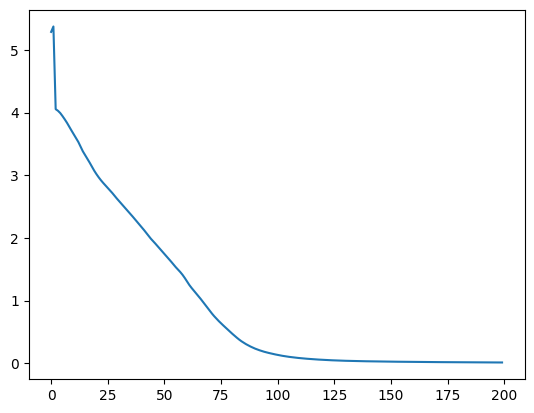

In [10]:
plt.plot(losses)
plt.show()

### Check loss on training sample vs non-training samples

In [11]:
def get_loss(ts, prompt, desc, model, ts_enc):
    with torch.no_grad():
        inputs_embeds, labels = preprocess(ts.float(), new_token_id, prompt, desc)
        loss = model(inputs_embeds=inputs_embeds, labels=labels).loss
    return loss

In [12]:
outputs = {
    "0": {
        "desc": desc_right,
        "ts": x,
        "loss": get_loss(x, prompt, desc_right, model, ts_enc)
    }
}

for i, desc in enumerate(desc_wrong):
    outputs[i+1] = {
        "desc": desc,
        "ts": x,
        "loss": get_loss(x, prompt, desc, model, ts_enc)
    }

for key in outputs:
    print(outputs[key]["desc"])
    print(outputs[key]["loss"])
    
# Takeaway: The model finds the correct description very likely!

This is a time series for seasonal temperature in celsius that spans 3 years.
tensor(0.0141)
This is a time series for seasonal temperature in celsius that spans -4 years.
tensor(1.7022)
This is a time series for seasonal temperature in celsius that spans 8 years.
tensor(0.8649)
This is a time series for seasonal temperature in celsius that spans 400 years.
tensor(0.9132)
